Learn the inter-grid operator ratio for interface problems using multigrid framework, dataset is constructed by changing RHS 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import h5py
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshHandler
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from Utils import plot

In [2]:
class RHSDataSet(Dataset):
    def __init__(self, h5file, case='train', transform=None, target_transform=None):
        """
        case = 'train' or 'test'
        """
        h5 = h5py.File(h5file,'r')
        self.data = np.array(h5[case], dtype=np.float32)
        self.totensor = ToTensor()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        rhs_tensor = self.totensor(self.data[idx])
        if self.transform:
            rhs_tensor = self.transform(rhs_tensor)
        return rhs_tensor

In [3]:
training_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='train')
test_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='test')

train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [4]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.property = [1, 20] # homogeneous problem
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshHandler(size, prop=self.property, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v


In [21]:
conv = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=2, bias=False) # restriction
for para in conv.parameters():
    print(para)

Parameter containing:
tensor([[[[-0.1265, -0.0966,  0.2835],
          [ 0.1703, -0.2969,  0.0947],
          [ 0.3295, -0.3004,  0.0914]]],


        [[[-0.1489, -0.3144,  0.1687],
          [-0.2771,  0.1670,  0.1141],
          [ 0.0477, -0.0079, -0.0549]]],


        [[[-0.3301,  0.0848, -0.2693],
          [-0.1670,  0.2334,  0.3320],
          [ 0.2510,  0.0643, -0.0502]]],


        [[[ 0.0064,  0.0074,  0.2841],
          [-0.0314,  0.0222, -0.1179],
          [-0.3320,  0.1293,  0.0373]]],


        [[[-0.1570, -0.3082,  0.1058],
          [ 0.1767,  0.1194, -0.1491],
          [-0.0920, -0.0658,  0.2773]]]], requires_grad=True)


In [5]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n = 64):
        super(MultiGrid, self).__init__()

        # Hyper parameters
        self.m = 6 # number of iterations to compute q

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        # Kernels for inter-grid communication 
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        restriction_kernel = torch.asarray([[1, 2, 1],
                                            [2, 4, 2],
                                            [1, 2, 1]], dtype=torch.float32) / 16.0
        self.conv.weight = nn.Parameter(restriction_kernel.reshape(1,1,3,3))
        self.conv.requires_grad_(False)

        self.deconv = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        interpolation_kernel = torch.asarray([[1, 2, 1],
                                              [2, 4, 2],
                                              [1, 2, 1]], dtype=torch.float32) / 4.0
        interpolation_kernel = interpolation_kernel #+ torch.randn((3,3))
        self.deconv.weight = nn.Parameter(interpolation_kernel.reshape(1,1,3,3))
        # self.deconv.requires_grad_(True)
        self.deconv.requires_grad_(False)

        self.w = nn.Parameter(torch.asarray([5.,2.], dtype=torch.float32))
        self.w.requires_grad_(True)
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def qm(self, x):
        "Compute the convergence factor after m iterations"
        res1 = self.f - self.grids[0].Knet(x)
        res0 = self.f - self.grids[0].Knet(self.v)
        return torch.mean(torch.pow(torch.norm(res1[:, :, 1:-1, 1:-1].clone(), dim=(2,3))/torch.norm(res0[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).detach(), 1.0/self.m))
    
    def forward(self, F):
        '''Input is RHS field F'''
        self.f = self.grids[0].fnet(F) # assign the finest rhs 
        self.v = torch.zeros_like(F, requires_grad=False, dtype=torch.float32) # initial solution
        U = torch.clone(self.v)
    
        for i in range(self.m-1):
            U = self.iterate(U).detach()
        return self.iterate(U)

    def iterate(self, x):
        '''Input x is the initial solution on the finest grid'''
        n_batches = x.shape[0]
        n_relax = 1 # number of relaxations
        self.grids[0].v = x
        self.grids[0].f = self.f
        self.grids[0].v = self.grids[0].Relax(self.grids[0].v, self.grids[0].f, n_relax)

        for j in range(0, self.L-1):
            rF = self.grids[j].f-self.grids[j].Knet(self.grids[j].v)
            self.grids[j+1].f = self.w[0]*self.Restrict(rF)
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.grids[j+1].v = self.grids[j+1].Relax(self.grids[j+1].v, self.grids[j+1].f, n_relax)

        self.grids[self.L-1].v = self.grids[self.L-1].Relax(self.grids[self.L-1].v, self.grids[self.L-1].f, n_relax)

        for j in range(self.L-2,-1,-1):
            error_delta = self.w[1]*self.Interpolate(self.grids[j+1].v)
            self.grids[j].v = self.grids[j].v + error_delta
            self.grids[j].v = self.grids[j].Relax(self.grids[j].v, self.grids[j].f, n_relax)

            # zero out the previous level solution
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.grids[0].v 

In [6]:
n = 2**4
model = MultiGrid(n)
rhs = next(iter(train_dataloader))

In [8]:
print(list(model.parameters()))

[Parameter containing:
tensor([5., 2.], requires_grad=True), Parameter containing:
tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]]), Parameter containing:
tensor([[[[0.2500, 0.5000, 0.2500],
          [0.5000, 1.0000, 0.5000],
          [0.2500, 0.5000, 0.2500]]]])]


0 4.012094020843506
1 54.49403381347656
2 709.92578125
3 9214.0703125
4 119549.875
5 1551072.5
6 20124016.0
7 261094944.0
8 3387520768.0
9 43950690304.0
10 570228015104.0
11 7398297698304.0
12 95987670450176.0
13 1245362274697216.0
14 1.6157684147421184e+16
15 2.096333679881093e+17
16 2.7198451460771676e+18
17 inf
The iteration doesn't converge!


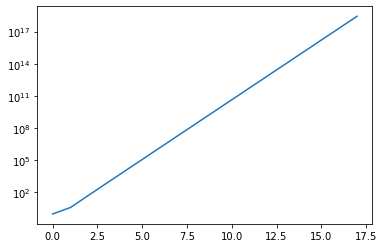

In [9]:
EPS = 5e-5
n_multigrid = 0
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[0].unsqueeze(0))
err_occured = False
while (abs(res) > EPS):
    u = model.iterate(u)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')

In [10]:
model_dir = 'Model/multigrid_rhs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.deconv.weight
model.w

Parameter containing:
tensor([5., 2.], requires_grad=True)

In [11]:
def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad() # zero the gradients for every batch
        u_out = model(data)
        loss_q = model.qm(u_out)
        
        loss_q.backward()
        optimizer.step()
        running_loss += loss_q.item()
    
    last_loss = running_loss/(i+1)
    return last_loss

In [12]:
num_epoch = 200
best_vloss = 1_000_000.

qm_train = []
for epoch in range(num_epoch):
    model.train(True)
    avg_q = train_one_epoch()
    print(epoch, avg_q)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,'model_multigrid_interface_ratio.pth')
    torch.save(model.state_dict(), mpath)
    qm_train.append(avg_q)

print("\nNew value:")
model.conv.weight
model.deconv.weight
model.w

0 9.355979263782501
1 9.058732867240906
2 8.727669954299927
3 8.405618041753769
4 8.131822258234024
5 7.848052352666855
6 7.581699430942535
7 7.332527816295624
8 7.079346090555191
9 6.844653904438019
10 6.612508237361908
11 6.3663844764232635
12 6.155193656682968
13 5.940372109413147
14 5.7516870200634
15 5.573063760995865
16 5.3820841908454895
17 5.216193318367004
18 5.032997757196426
19 4.880579322576523
20 4.725806534290314
21 4.5605170130729675
22 4.414492055773735
23 4.254294231534004
24 4.117439568042755
25 3.9990731924772263
26 3.8725923746824265
27 3.7323185354471207
28 3.6196508705615997
29 3.503454089164734
30 3.3861660063266754
31 3.276307135820389
32 3.174918293952942
33 3.073235422372818
34 2.9637115001678467
35 2.874814197421074
36 2.795670971274376
37 2.6902707517147064
38 2.612274691462517
39 2.5282696783542633
40 2.447811931371689
41 2.3693147748708725
42 2.2979877442121506
43 2.2186896726489067
44 2.152975931763649
45 2.07902017980814
46 2.0122648254036903
47 1.945345

Parameter containing:
tensor([4.1366, 1.0217], requires_grad=True)

Text(0.5, 0, 'epoch')

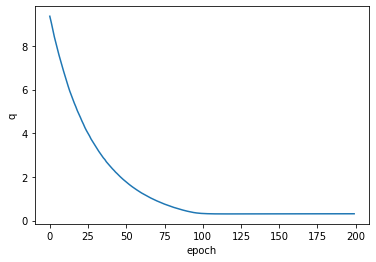

In [13]:
plt.plot(qm_train)
plt.ylabel('q')
plt.xlabel('epoch')

In [14]:
# import the learned model
model.load_state_dict(torch.load(os.path.join(model_dir,'model_multigrid_interface_ratio.pth')))
model.w

Parameter containing:
tensor([4.1366, 1.0217], requires_grad=True)

In [15]:
EPS = 5e-5
n_multigrid = 0
n = 2**4
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[0].unsqueeze(0))
while (abs(res) > EPS):
    u = model.iterate(u)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

print("Solution converges after", n_multigrid, "multi-grid iterations ")

0 0.17239314317703247
1 0.026355136185884476
2 0.007713542319834232
3 0.001988314324989915
4 0.0006820597918704152
5 0.00021763096447102726
6 7.579687371617183e-05
7 2.574432255642023e-05
Solution converges after 8 multi-grid iterations 


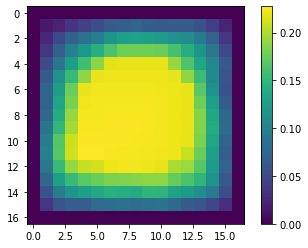

In [16]:
plot.plot_field(u.detach())

In [17]:
# Test the multigrid iteration
class Multigrid():
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        # Problem parameters
        C = 0.0
        k = 1
        l = 2

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.w = inter_model.w.detach()
        self.restrict_kernel = inter_model.conv.weight.detach()
        self.interpolate_kernel = inter_model.deconv.weight.detach()
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs

    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, f):
        '''
        Perform full weighting operation to down sample to next level
        '''
        f_res = f[:, :, 1:-1, 1:-1]
        f_res = F.conv2d(f_res, self.restrict_kernel, stride=2)
        #f_res = F.conv2d(f_res, self.restrict_kernel, stride=2)
        return F.pad(f_res,(1,1,1,1),"constant",0) # pad with zeros

    def Interpolate(self, v):
        '''
        Perform linear interpolation and upsample to previous level ==> Return size: (2*N - 1), Ex. 17 -> 33
        '''
        v = F.conv_transpose2d(v, self.interpolate_kernel, stride=2, padding=1)
        #v = F.conv_transpose2d(v, self.interpolate_kernel, stride=2, padding=1)
        return v

    def Error(self,v):
        '''
        Compute the error between current approximation and exact solution
        v should be a 1D vector
        '''
        return torch.linalg.norm(v.reshape(-1)-self.u_exact.reshape(-1), ord=torch.inf)
    
    def rec_V_cycle(self, l, v, f):
        '''
        Perform recursive V-cycle
        Input: l, current level
        '''
        n_sample = 1
        self.grids[l].v = v
        self.grids[l].f = f
        self.grids[l].v = self.grids[l].Relax(v, f, n_sample)
        if(not self.grids[l].IsCoarsest()):
            residual = self.grids[l].f-self.grids[l].Knet(self.grids[l].v)
            self.grids[l+1].f = self.w[0]*self.Restrict(residual)
            self.grids[l+1].v *= 0.
            self.rec_V_cycle(l+1, self.grids[l+1].v, self.grids[l+1].f)
            self.grids[l].v += self.w[1]*self.Interpolate(self.grids[l+1].v)
            self.grids[l+1].v *= 0.
        
        self.grids[l].v = self.grids[l].Relax(self.grids[l].v,self.grids[l].f,n_sample) 

    def Solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.randn((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.rec_V_cycle(0,self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

4.475809268504716 50.888126373291016
0.6873093638209233 8.288663864135742
0.20439679033060287 1.7277188301086426
0.07314499007514233 0.4121944308280945
0.02841532656192331 0.11376380920410156
0.01095898574684202 0.035953979939222336
0.004221198193569883 0.012496556155383587
0.0016214166070826156 0.004561832174658775
0.0006212240148251881 0.00170436454936862
0.00023773217127327732 0.0006440969300456345
9.11605076873693e-05 0.00024463460431434214
3.5185711131952e-05 9.317046351497993e-05
1.3698110956647878e-05 3.6271427234169096e-05
Solution converges after 13 V-cycle iterations with relative error of 1.3698110956647878e-05


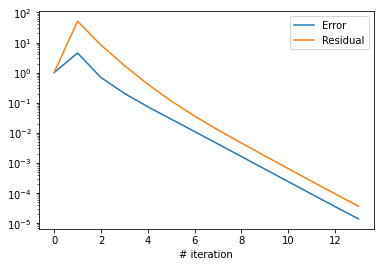

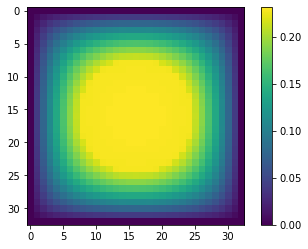

In [18]:
# Multigrid implementation
n = 2**5
prob_mg = Multigrid(model, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.Solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())